In [1]:
%pip install -q scikit-learn tensorflow matplotlib seaborn

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
import numpy as np
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Note: you may need to restart the kernel to use updated packages.


c:\Users\Lenovo\anaconda3\envs\PlantDisease\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# Dataset Configuration
TRAIN_PATH = "Training"
TEST_PATH = "Testing"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary'] 

📂 Loading datasets...
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


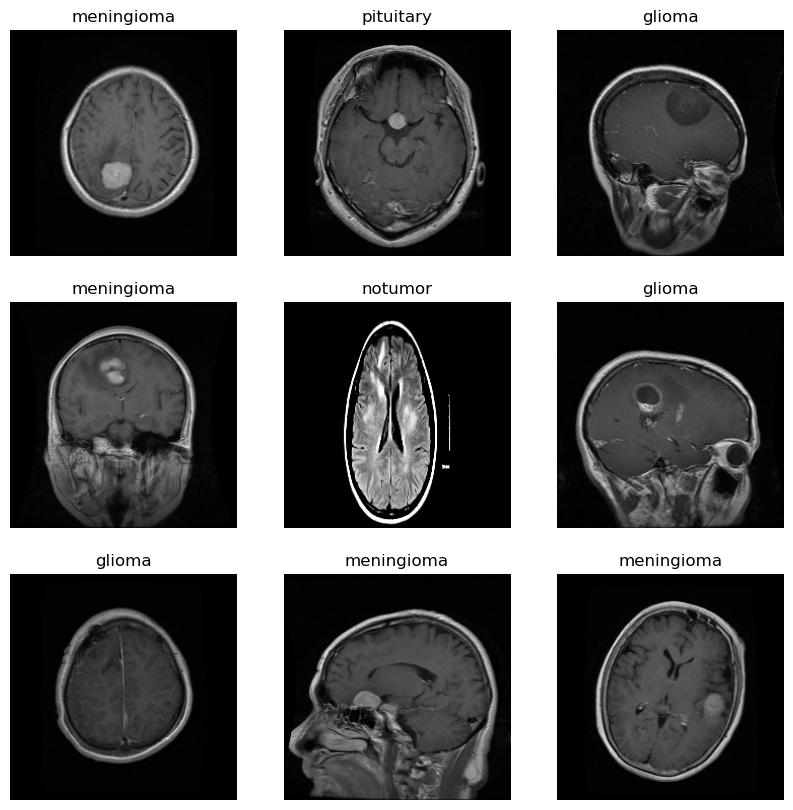

In [3]:
# Load datasets
print("📂 Loading datasets...")
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical',
    class_names=CLASS_NAMES
)

test_ds = image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False,
    class_names=CLASS_NAMES
)

# Split training into train/val
val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[tf.argmax(labels[i])])
        plt.axis("off")

In [4]:
def build_model(base_model_name, input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    # Base model selection
    if base_model_name == 'mobilenet':
        base_model = tf.keras.applications.MobileNetV3Large(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet',
            include_preprocessing=True
        )
    elif base_model_name == 'resnet':
        base_model = tf.keras.applications.ResNet50(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
    elif base_model_name == 'efficientnet':
        base_model = tf.keras.applications.EfficientNetB0(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
    else:
        raise ValueError("Unsupported model name")

    base_model.trainable = False  # Freeze base model

    # Build custom head
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize models
models = {
    'MobileNetV3': build_model('mobilenet'),
    'ResNet50': build_model('resnet'),
    'EfficientNetB0': build_model('efficientnet')
}

In [5]:
def train_model(model, train_data, val_data, epochs, model_name):
    print(f"\n🚀 Training {model_name}...")
    start = time.time()
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        verbose=1
    )
    end = time.time()
    
    # Save model and history
    model.save(f'{model_name}_brain_tumor.keras')
    with open(f'{model_name}_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    
    print(f"✅ Training completed in {(end-start):.2f}s")
    return history, end-start

# Train all models
results = {}
for name, model in models.items():
    history, train_time = train_model(model, train_ds, val_ds, epochs=10, model_name=name)
    results[name] = {'history': history, 'train_time': train_time}


🚀 Training MobileNetV3...
Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 102s 612ms/step - accuracy: 0.4698 - loss: 1.2451 - val_accuracy: 0.8500 - val_loss: 0.4755
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 74s 514ms/step - accuracy: 0.8178 - loss: 0.5074 - val_accuracy: 0.8830 - val_loss: 0.3547
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 473ms/step - accuracy: 0.8589 - loss: 0.3925 - val_accuracy: 0.8929 - val_loss: 0.3041
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 72s 498ms/step - accuracy: 0.8747 - loss: 0.3461 - val_accuracy: 0.9054 - val_loss: 0.2750
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 485ms/step - accuracy: 0.8845 - loss: 0.3086 - val_accuracy: 0.9089 - val_loss: 0.2546
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 129s 899ms/step - accuracy: 0.8998 - loss: 0.2815 - val_accuracy: 0.9134 - val_loss: 0.2381
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 441ms/step - accuracy: 0.9074 - loss: 0.2584 - val_accuracy: 0.9125 - val_loss: 0.2299
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 425ms/step


🔍 Evaluating MobileNetV3...
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.85      0.89       300
  meningioma       0.82      0.84      0.83       306
     notumor       0.95      0.98      0.96       405
   pituitary       0.93      0.97      0.95       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.91      0.91      0.91      1311



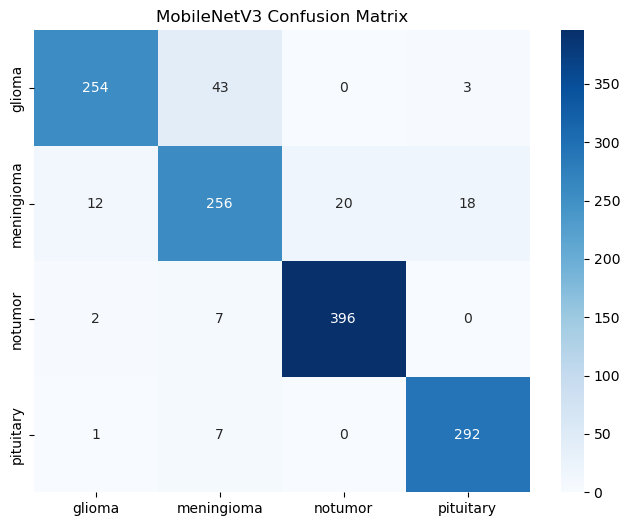


🔍 Evaluating ResNet50...
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step
              precision    recall  f1-score   support

      glioma       0.94      0.87      0.90       300
  meningioma       0.85      0.87      0.86       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



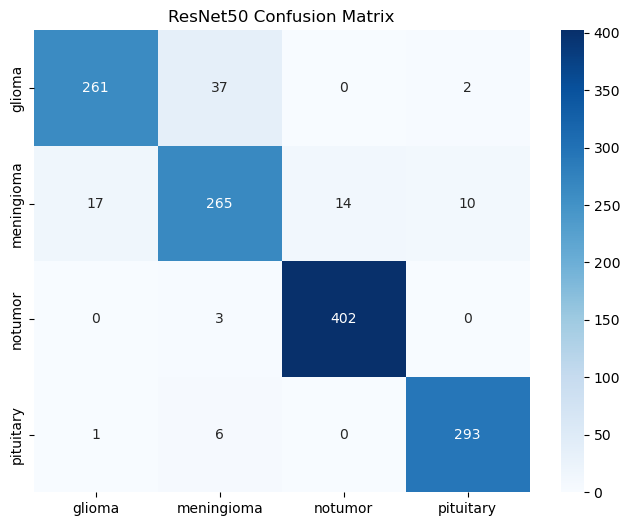


🔍 Evaluating EfficientNetB0...
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step
              precision    recall  f1-score   support

      glioma       0.87      0.82      0.84       300
  meningioma       0.79      0.79      0.79       306
     notumor       0.94      0.97      0.96       405
   pituitary       0.94      0.96      0.95       300

    accuracy                           0.89      1311
   macro avg       0.88      0.88      0.88      1311
weighted avg       0.89      0.89      0.89      1311



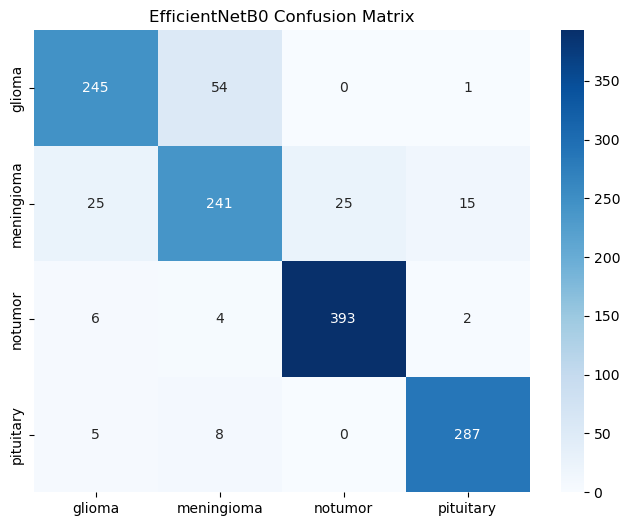

In [6]:
def evaluate_model(model, test_data, model_name):
    print(f"\n🔍 Evaluating {model_name}...")
    
    # Get true and predicted labels
    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(model.predict(test_data), axis=1)
    
    # Metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro')
    }
    
    # Classification report
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    return metrics

# Evaluate all models
for name, model in models.items():
    metrics = evaluate_model(model, test_ds, name)
    results[name].update(metrics)

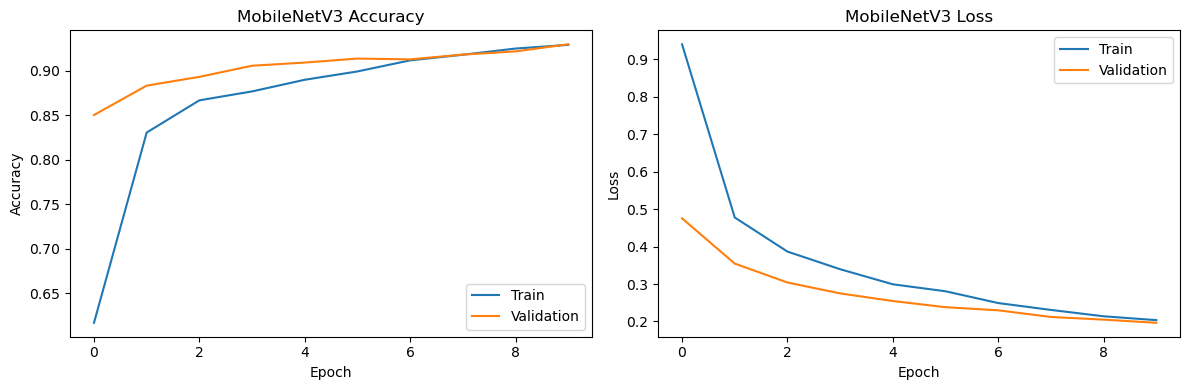

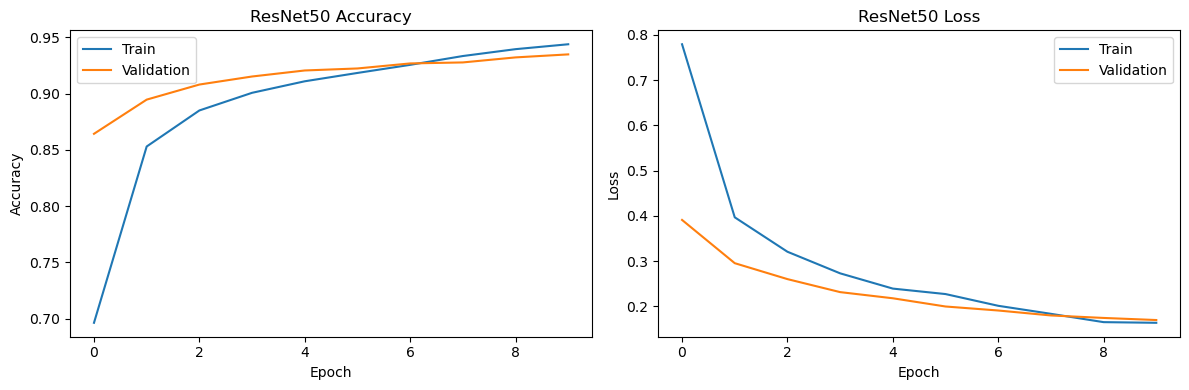

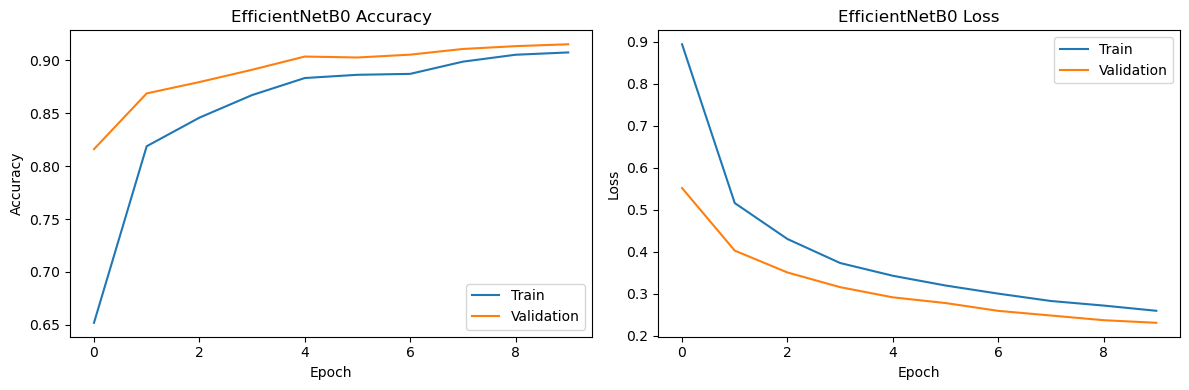


📊 Model Comparison:


,Model,Accuracy,F1 Score,Training Time (s),Model Size (MB)
1,ResNet50,0.931350,0.927110,3505.412510,93.617665
0,MobileNetV3,0.913806,0.909326,763.514647,13.502170
2,EfficientNetB0,0.889397,0.883368,1042.536010,18.139707


In [7]:
# Training curves
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for each model
for name in models:
    plot_history(results[name]['history'], name)

# Model comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [res['accuracy'] for res in results.values()],
    'F1 Score': [res['f1'] for res in results.values()],
    'Training Time (s)': [res['train_time'] for res in results.values()],
    'Model Size (MB)': [os.path.getsize(f'{name}_brain_tumor.keras')/(1024*1024) for name in results]
})

print("\n📊 Model Comparison:")
display(comparison_df.sort_values('Accuracy', ascending=False))

In [8]:
# Save all results
with open('brain_tumor_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("💾 All results saved to disk")

💾 All results saved to disk
